In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('events.csv')

In [144]:
df_events = df[['user_session', 'cluster', 'event_type']].drop_duplicates()

In [145]:
#퍼널 전환율 계산
funnel = pd.DataFrame(df_events.groupby('event_type')['user_session'].count()).reset_index()

In [146]:
stage = {
    'view': 0,
    'cart': 1,
    'purchase': 2
}

funnel['stage'] = funnel['event_type'].map(stage)

In [147]:
funnel = funnel.sort_values(by='stage').reset_index()

In [148]:
del funnel['index']

In [149]:
for i in range(len(funnel)):
    if i==0:
        funnel.loc[i, 'conversion_rate'] = None
    else:
        funnel.loc[i, 'conversion_rate'] = round(funnel.loc[i, 'user_session'] / funnel.loc[i-1, 'user_session'] *100, 2)

In [150]:
funnel

,event_type,user_session,stage,conversion_rate
0,view,488397,0,NaN
1,cart,41277,1,8.45
2,purchase,24346,2,58.98


In [153]:
fig = px.funnel(funnel, x='user_session', y='event_type', orientation='h', text='conversion_rate', width=800, height=600)
fig.show()

In [ ]:
#고객 segmentation

In [ ]:
# RFM 이외에 브랜드 제품 구매 비율 변수를 추가해서 고객 분류

In [11]:
df['datetime'] = pd.to_datetime(df['event_time'])

In [12]:
df_purchase = df[df['event_type']=='purchase'] #제품을 구매한 고객 데이터만 대상으로 함.
recent_date = pd.DataFrame(df_purchase.groupby(['user_id'])['datetime'].max().reset_index())

recent_date['recency'] = recent_date.datetime > '2020-12-01'

In [13]:
# Frequency: 고객별 주문건수 확인
# 주문 건별 아이디가 없어 같은 세션에서 구매했으면 같은 주문일 것으로 가정하고 세션을 카운트함.
freq = pd.DataFrame(df_purchase.groupby(['user_id'])['user_session'].count()).reset_index()
freq = freq.rename(columns={'user_session':'orders'})

In [14]:
# Monetary: 고객별 주문금액 집계
monetary = pd.DataFrame(df_purchase.groupby(['user_id'])['price'].sum()).reset_index()

In [15]:
# 브랜드 상품 구매 비율 계산
brand_purchase = pd.DataFrame(df_purchase.groupby(['user_id']).count()[['product_id', 'brand']]).reset_index()
brand_purchase['brand_pref'] = brand_purchase['brand'] / brand_purchase['product_id']

In [16]:
rf = pd.merge(recent_date, freq, how='right', on='user_id')
rfm = pd.merge(rf, monetary, how='right', on='user_id')
brand_purchase = brand_purchase[['user_id', 'brand_pref']]
rfmb = pd.merge(rfm, brand_purchase, how='right', on='user_id')
del rfmb['datetime']

<AxesSubplot:>

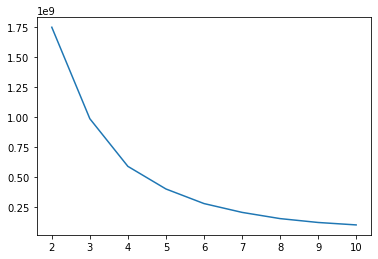

In [17]:
from sklearn.cluster import KMeans
rfmb = pd.get_dummies(rfmb, columns=['recency'], drop_first = True)
rfmb.set_index('user_id', inplace=True)


#적정그룹수 정하기
inertia = []

for i in range(2, 11):
    model = KMeans(n_clusters=i)
    model.fit(rfmb)
    inertia.append(model.inertia_)
    
sns.lineplot(x=list(range(2,11)), y=inertia)

In [18]:
# 4개를 클러스터 개수로 정하고 클러스터링 진행

model = KMeans(n_clusters=4)
model.fit(rfmb)
rfmb['cluster'] = model.labels_

In [19]:
pd.DataFrame(rfmb.groupby(by='cluster')['orders'].count()).rename(columns={'orders':'users'})

,users
cluster,
0,16574
1,812
2,3833
3,85


In [20]:
summary = rfmb.groupby('cluster').mean().reset_index()

<AxesSubplot:xlabel='cluster', ylabel='recency_True'>

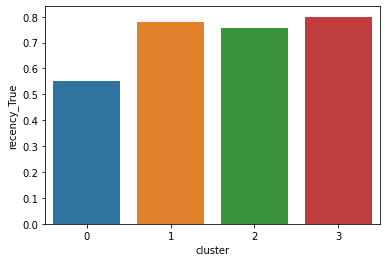

In [21]:
sns.barplot(x='cluster', y='recency_True', data=summary)

<AxesSubplot:xlabel='cluster', ylabel='orders'>

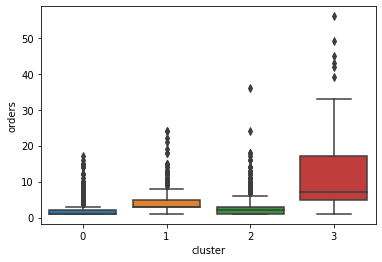

In [22]:
sns.boxplot(x='cluster', y='orders', data=rfmb)

<AxesSubplot:xlabel='cluster', ylabel='price'>

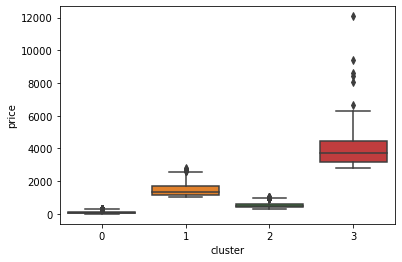

In [23]:
sns.boxplot(x='cluster', y='price', data=rfmb)

<AxesSubplot:xlabel='cluster', ylabel='brand_pref'>

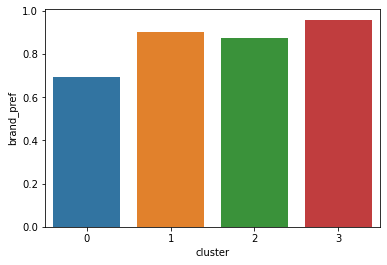

In [24]:
sns.barplot(x='cluster', y='brand_pref', data=summary)

In [25]:
rfmb_re = rfmb[['cluster']].reset_index()

In [29]:
df = pd.merge(df, rfmb_re, on='user_id', how='left')

In [32]:
df['cluster'] = df['cluster'].fillna(4)

In [109]:
df_events = df[['user_session', 'cluster', 'event_type']].drop_duplicates()

In [132]:
#퍼널 전환율 계산
funnel_cluster = pd.DataFrame(df_events.groupby(['cluster', 'event_type'])['user_session'].count())

In [133]:
funnel_cluster_re = funnel_cluster.reset_index()

In [134]:
stage = {
    'view': 0,
    'cart': 1,
    'purchase': 2
}

funnel_cluster_re['stage'] = funnel_cluster_re['event_type'].map(stage)

In [140]:
funnel_cluster_re = funnel_cluster_re.sort_values(by=['cluster', 'stage'], ascending=True)

In [142]:
fun_cls_0 = funnel_cluster_re[funnel_cluster_re['cluster']==0]
fun_cls_1 = funnel_cluster_re[funnel_cluster_re['cluster']==1]
fun_cls_2 = funnel_cluster_re[funnel_cluster_re['cluster']==2]
fun_cls_3 = funnel_cluster_re[funnel_cluster_re['cluster']==3]
fun_cls_4 = funnel_cluster_re[funnel_cluster_re['cluster']==4]

In [143]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=2)

fig.add_trace(go.Funnel(
                        name='cluster 0',
                        x=fun_cls_0['user_session'],
                        y=fun_cls_0['event_type'],
                        textinfo = "value+percent initial"
                        ),
            row=1, col=1)

fig.add_trace(go.Funnel(
                        name='cluster 1',
                        x=fun_cls_1['user_session'],
                        y=fun_cls_1['event_type'],
                        textinfo = "value+percent initial"
                        ),
              row=1, col=2)


fig.add_trace(go.Funnel(
                        name='cluster 2',
                        x=fun_cls_2['user_session'],
                        y=fun_cls_2['event_type'],
                        textinfo = "value+percent initial"
                        ),
              row=2, col=1)

fig.add_trace(go.Funnel(
                        name='cluster 3',
                        x=fun_cls_3['user_session'],
                        y=fun_cls_3['event_type'],
                        textinfo = "value+percent initial"
                        ),
              row=2, col=2)

fig.add_trace(go.Funnel(
                        name='cluster 4',
                        x=fun_cls_4['user_session'],
                        y=fun_cls_4['event_type'],
                        textinfo = "value+percent initial"
                        ),
              row=3, col=1)

fig.update_layout(height=800, width=800, title_text="Funnel Conversion by Customer Cluster")

fig.show()